In [1]:
import pyrootutils
root = pyrootutils.setup_root(
    search_from="./",
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

In [2]:
import os
import json
import yaml
import importlib
import argparse

import numpy as np

import ipywidgets as widgets
import matplotlib.pyplot as plt

import mitsuba as mi
mi.set_variant("cuda_ad_rgb")

from models.tcnn_ingp import TCNNInstantNGP
from models.triplane import Net

from utils.utils import gradient
from utils.polyfit_utils import pfit_grad_est
from utils.fd_utils import fd_stencil_cen
from utils.rendering import load_model_ckpt, get_ad_gradients, get_ray_trace_img, get_sphere_tracer_img, shader_dict
from utils.sphere_tracer import Camera

import matplotlib
font = {'size': 20}
matplotlib.rc('font', **font)



# Rendering settings

Settings like camera pose and intrinsics, checkpoint paths and operator parameters for rendering are described below.

If you would like to add your own shape, follow the same format as shown below.

In [3]:
# model checkpoints and parameters required for rendering
settings_dict = {
    "sphere":  {
        "pt_ckpt": "checkpoints/sphere_ingp/",
        "ft_ckpt": "checkpoints/sphere_ingp_ft/",
        "scene_xml": "utils/rendering_assets/scene.xml",
        "shader": "mirror",
        "camera": {
            "origin": [0, 0, -1.0],
            "focal_length": 0.6,
            "res_h": 480,
            "res_w": 480
        },
        "pfit": {
            "sigma": 0.03,
            "n_walks": 256
        },
        "sphere": True
    },
    "armadillo": {
        "pt_ckpt": "checkpoints/armadillo_ingp/",
        "ft_ckpt": "checkpoints/armadillo_ingp_ft/",
        "scene_xml": "utils/rendering_assets/scene_armadillo.xml",
        "shader": "diffuse",
        "camera": {
            "origin": [0.0, 0.1, -0.5],
            "focal_length": 3,
            "res_h": 480,
            "res_w": 480
        },
        "pfit": {
            "sigma": 0.002,
            "n_walks": 256
        },
        "sphere": False
    }
    
}

# Select the shape you want to render

In [4]:
# dropdown to select shape
shape = widgets.Dropdown(
    options=['sphere', 'armadillo'],
    value='sphere',
    description='Shape:',
    disabled=False,
)
shape

Dropdown(description='Shape:', options=('sphere', 'armadillo'), value='sphere')

In [5]:
settings = settings_dict[shape.value]
print("Settings for rendering:\n")
print(json.dumps(settings, indent=4))

Settings for rendering:

{
    "pt_ckpt": "checkpoints/sphere_ingp/",
    "ft_ckpt": "checkpoints/sphere_ingp_ft/",
    "scene_xml": "utils/rendering_assets/scene.xml",
    "shader": "mirror",
    "camera": {
        "origin": [
            0,
            0,
            -1.0
        ],
        "focal_length": 0.6,
        "res_h": 480,
        "res_w": 480
    },
    "pfit": {
        "sigma": 0.03,
        "n_walks": 256
    },
    "sphere": true
}


# Loading the models

Load the pre-trained and fine-tuned checkpoints

In [6]:
pt_model = load_model_ckpt(settings["pt_ckpt"])
ft_model = load_model_ckpt(settings["ft_ckpt"])

Net(
  (encoder): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float32, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 19, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.3819128274917603, 'type': 'Hash'})
  (backbone): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=False)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=False)
  )
)
Net(
  (encoder): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float32, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 19, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.3819128274917603, 'type': 'Hash'})
  (backbone): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=False)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=False)
  )
)


# Camera setup

In [7]:
camera_cfg = settings["camera"]
h, w = camera_cfg["res_h"], camera_cfg["res_w"]

camera = Camera(
    origin = np.array(camera_cfg["origin"]),
    focal_length = camera_cfg["focal_length"],
    resolution = (h, w)
)

# Generate images

In [8]:
# select shader
shader_type = settings["shader"] 
# flag to rotate rendered imaged before plotting (for non-sphere)
rot = not settings["sphere"]

# generate ray-traced image for reference
scene_xml_fn = settings["scene_xml"]
rt_image = get_ray_trace_img(scene_xml_fn, camera, shader_dict[shader_type], rot)

# using AD gradients from pre-trained model
ad_img = get_sphere_tracer_img(
    pt_model,
    camera,
    get_ad_gradients,
    shader_dict[shader_type],
    rot
)

# using posthoc polynomial-fitting gradients from pre-trained model
pfit_sigma =  settings["pfit"]["sigma"]
pfit_n_walks = settings["pfit"]["n_walks"]
# NOTE: If encountering memory issues, set doall=False and play with batch_size
pfit_est = lambda x, model: pfit_grad_est(x, model, n_walks=pfit_n_walks, sigma=pfit_sigma, doall=True, bs=8192, norm=True).detach().cpu()

pfit_img = get_sphere_tracer_img(
    pt_model,
    camera,
    pfit_est,
    shader_dict[shader_type],
    rot
)

# using AD gradients from fine-tuned model
ad_img_ft = get_sphere_tracer_img(
    ft_model,
    camera,
    get_ad_gradients,
    shader_dict[shader_type],
    rot
)

# Plot the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


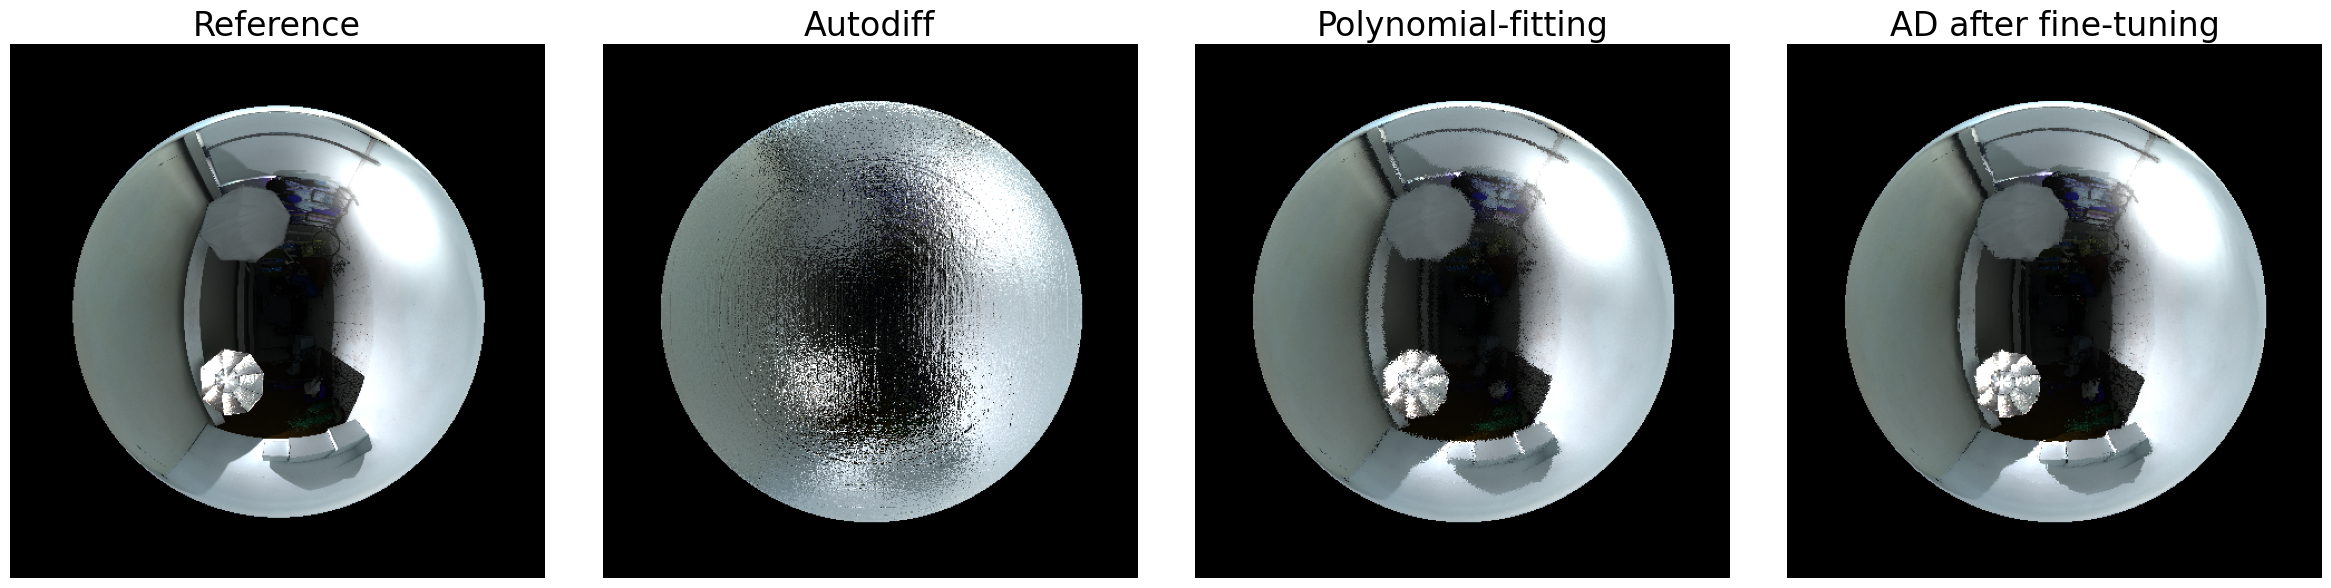

In [9]:
f, axarr = plt.subplots(1, 4, figsize=(24, 6))
labels = ["Reference", "Autodiff", "Polynomial-fitting", "AD after fine-tuning"]
images = [rt_image, ad_img, pfit_img, ad_img_ft]

for i in range(4):
    axarr[i].imshow(images[i])
    axarr[i].set_title(labels[i])
    axarr[i].axis("off")
    
plt.tight_layout()
plt.show()